# Marine Heatwaves Definition for NZ 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import xarray as xr 
import geopandas as gpd
from cartopy import crs as ccrs 
import cartopy.feature as cfeature

In [3]:
from dask.diagnostics import ProgressBar

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [5]:
# Load marineHeatWaves definition module from Eric C Oliver 
import marineHeatWaves as mhw

In [6]:
def make_mask(box, dset): 
    import regionmask
    region = regionmask.from_geopandas(box)
    mask = region.mask(dset) 
    mask = mask.where(np.isnan(mask), 1.) 
    return mask 

In [7]:
def make_regional_ts(dset, varname='sst', mask='tasman_mask', name='Tasman', start_year=1982): 
    box_masked = dset['sst'] * dset[mask]
    box_ts = box_masked.mean(dim = ['lat','lon'])
    box_ts = box_ts.to_dataframe(name=name)
    box_ts = box_ts.loc[str(start_year):,:]
    return box_ts

In [8]:
def detect_MWHs(ts, climatology=[1982,2011], verbose=True): 
    
    dates_pandas = ts.index
    
    start_date = dates_pandas.to_pydatetime()[0].date()
    
    end_date = dates_pandas.to_pydatetime()[-1].date()
    
    t = np.arange(start_date.toordinal(),end_date.toordinal()+1)
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    sst = ts.values.flatten()
    
    mhws, clim = mhw.detect(t, sst, climatologyPeriod=climatology)
    
    if verbose:

        ev = np.argmax(mhws['intensity_max']) # Find largest event
        print('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
        print('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
        print('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
        print('Duration:', mhws['duration'][ev], 'days')
        print('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
        print('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))
    
    df_mhws = pd.DataFrame(mhws)
    
    return t, mhws, df_mhws, ev

In [9]:
def make_block_average(t, mhws, block_length=1): 
    
    mhwBlock = mhw.blockAverage(t, mhws, blockLength=block_length)
    
    df_mhwBlock = pd.DataFrame(mhwBlock)
    
    df_mhwBlock = df_mhwBlock.set_index('years_centre', drop=False)
    
    df_mhwBlock.index.name = 'year (centre)'
    
    return mhwBlock, df_mhwBlock 

In [10]:
def make_time_series_plot(df_blocks, name_fname=None): 
    
    f, axes = plt.subplots(ncols=3, figsize=(18, 4));

    ax = axes[0]

    df_blocks.loc[:,'count'].plot(marker='o', ax=ax);
    ax.grid(ls=':');
    ax.set_ylabel('count');
    ax.set_title(f"{name}, Number of MHWs per {block_length} years");

    ax = axes[1]

    df_blocks.loc[:,'intensity_max'].plot(marker='o', ax=ax);
    ax.grid(ls=':');
    ax.set_ylabel(r'[$^\circ$C]');
    ax.set_title(f"{name}, Average MHW maximum intensity per {block_length} years");
    
    ax = axes[2]

    df_blocks.loc[:,'total_days'].plot(marker='o', ax=ax);
    ax.grid(ls=':');
    ax.set_ylabel('days');
    ax.set_title(f"{name}, total days");

    if name_fname is not None: 
        f.savefig(f'./{name_fname}_MHW_stat_per_{block_length}_year.png', dpi=200, bbox_inches='tight', facecolor='w')    

### read shapefiles 

In [11]:
nz_box = gpd.read_file('./shapefiles/nz_box.geojson')

In [12]:
tasman_box = gpd.read_file('./shapefiles/tasman.geojson')

In [13]:
eastern_tasman_box = gpd.read_file('./shapefiles/eastern_tasman.geojson')

In [14]:
nz_6_regions = gpd.read_file('/home/nicolasf/data/shapefiles/NZ/6regions/NZ_regions/NZ_regions_corrected/NZ_regions_corrected.shp')

In [15]:
nz_6_regions = nz_6_regions.to_crs('EPSG:4326')

### apply a buffer of 2.5 degrees 

In [16]:
nz_6_regions_buffer = nz_6_regions.buffer(distance=2.5)

### data munging on the dataframe 

In [17]:
nz_6_regions_buffer = nz_6_regions_buffer.to_frame()

In [18]:
nz_6_regions_buffer.columns = ['geometry']

In [19]:
nz_6_regions_buffer.index = nz_6_regions.index

In [20]:
nz_6_regions_buffer.loc[:,'Location'] = nz_6_regions.loc[:,'Location']

### plots the regions' boundaries 

#### NZ "6 regions"

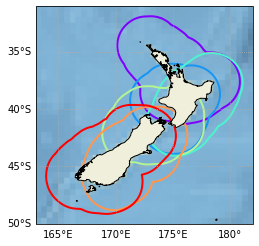

In [21]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# nz_box.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='g', lw=2)
nz_6_regions_buffer.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='rainbow', lw=2)
ax.stock_img()
ax.add_feature(cfeature.LAND, zorder=11)
# ax.add_feature(cfeature.OCEAN, zorder=1)
ax.coastlines(resolution='10m', zorder=12)
gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=np.arange(-180, 180, 5), ylocs = np.arange(-60,-20, 5), crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

#### Tasman boxes 

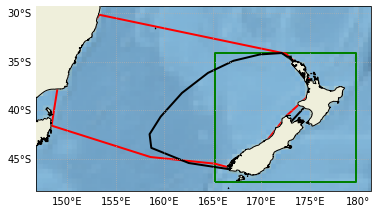

In [22]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
nz_box.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='g', lw=2)
tasman_box.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='r', lw=2)
eastern_tasman_box.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', lw=2)
ax.stock_img()
ax.add_feature(cfeature.LAND, zorder=11)
# ax.add_feature(cfeature.OCEAN, zorder=1)
ax.coastlines(resolution='10m', zorder=12)
gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=np.arange(-180, 180, 5), ylocs = np.arange(-60,-20, 5), crs=ccrs.PlateCarree())
gl.top_labels = False;
gl.right_labels = False;

### open the dataset of daily average SST (NOAA OISST)

In [23]:
def preprocess(dset): 
    dset = dset.sel(lon=slice(145, 180), lat=slice(-55., -20.))
    return dset

In [24]:
dpath = HOME.joinpath('data/SST/NOAA_hires_1981_present')

In [25]:
lfiles = list(dpath.glob("sst.day.mean.????.nc")) 

In [26]:
lfiles.sort()

In [27]:
lfiles[0]

PosixPath('/home/nicolasf/data/SST/NOAA_hires_1981_present/sst.day.mean.1981.nc')

In [28]:
lfiles[-1]

PosixPath('/home/nicolasf/data/SST/NOAA_hires_1981_present/sst.day.mean.2021.nc')

In [29]:
dset = xr.open_mfdataset(lfiles, preprocess=preprocess, parallel=True)

In [30]:
with ProgressBar(): 
    dset = dset.compute()

[########################################] | 100% Completed |  4min 13.8s


In [31]:
dset

<xarray.Dataset>
Dimensions:  (lat: 140, lon: 140, time: 14468)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2021-04-11
  * lat      (lat) float32 -54.88 -54.62 -54.38 -54.12 ... -20.62 -20.38 -20.12
  * lon      (lon) float32 145.1 145.4 145.6 145.9 ... 179.1 179.4 179.6 179.9
Data variables:
    sst      (time, lat, lon) float32 1.31 1.41 1.57 1.82 ... 27.62 27.56 27.58
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....

### makes the mask and add to the dataset 

In [32]:
for region_name in ['NNI','WNI','ENI','NSI','WSI','ESI']: 
    nz_reg = nz_6_regions_buffer.query(f"Location == '{region_name}'")
    mask = make_mask(nz_reg, dset)
    dset[region_name] = mask

In [33]:
dset['tasman_mask'] = make_mask(tasman_box, dset)

In [34]:
dset['nz_mask'] = make_mask(nz_box, dset)

In [35]:
dset['eastern_tasman_mask'] = make_mask(eastern_tasman_box, dset)

In [36]:
dset

<xarray.Dataset>
Dimensions:              (lat: 140, lon: 140, time: 14468)
Coordinates:
  * time                 (time) datetime64[ns] 1981-09-01 ... 2021-04-11
  * lat                  (lat) float32 -54.88 -54.62 -54.38 ... -20.38 -20.12
  * lon                  (lon) float32 145.1 145.4 145.6 ... 179.4 179.6 179.9
Data variables:
    sst                  (time, lat, lon) float32 1.31 1.41 1.57 ... 27.56 27.58
    NNI                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    WNI                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ENI                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    NSI                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    WSI                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ESI                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    tasman_mask          (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    nz_mask              (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    eastern_tasman_mask  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....

### makes the regional time-series 

In [37]:
Eastern_Tasman_ts = make_regional_ts(dset, mask='eastern_tasman_mask', name='Eastern Tasman')

In [38]:
Tasman_ts = make_regional_ts(dset, mask='tasman_mask', name='Tasman')

In [39]:
NZbox_ts = make_regional_ts(dset, mask='nz_mask', name='NZ box')

In [40]:
NNI = make_regional_ts(dset, mask='NNI', name='NNI')

In [41]:
WNI = make_regional_ts(dset, mask='WNI', name='WNI')

In [42]:
ENI = make_regional_ts(dset, mask='ENI', name='ENI')

In [43]:
NSI = make_regional_ts(dset, mask='NSI', name='NSI')

In [44]:
WSI = make_regional_ts(dset, mask='WSI', name='WSI')

In [45]:
ESI = make_regional_ts(dset, mask='ESI', name='ESI')

### quick plot of some of the time-series 

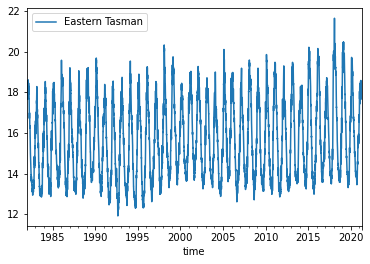

In [46]:
Eastern_Tasman_ts.plot()

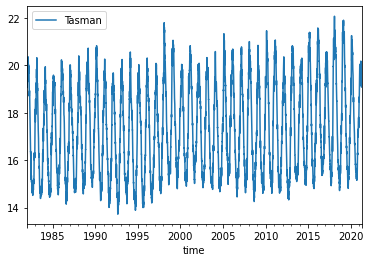

In [47]:
Tasman_ts.plot()

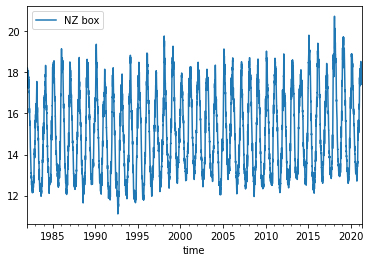

In [48]:
NZbox_ts.plot()

### dictionnary mapping name to time-series to analyse 

In [49]:
dts = {}
dts['NZ box'] = NZbox_ts
dts['Tasman'] = Tasman_ts
dts['Eastern Tasman'] = Eastern_Tasman_ts 

dts['NNI'] = NNI
dts['WNI'] = WNI
dts['ENI'] = ENI
dts['NSI'] = NSI
dts['WSI'] = WSI
dts['ESI'] = ESI

### name of the time-series to analyse 

In [50]:
block_length = 1 # in years 

------------------------------------------------------------------------------
>>>>> NZ box <<<<<
------------------------------------------------------------------------------
Maximum intensity: 3.418583482642676 deg. C
Average intensity: 1.834677781678065 deg. C
Cumulative intensity: 278.8710228150659 deg. C-days
Duration: 152 days
Start date: 20 November 2017
End date: 20 April 2018

Ranks:


The 2017-11-20 to 2018-04-20 MHW event is ranked number 2 by duration

The 2017-11-20 to 2018-04-20 MHW event is ranked number 1 by maximum intensity

The 2017-11-20 to 2018-04-20 MHW event is ranked number 1 by mean intensity

The 2017-11-20 to 2018-04-20 MHW event is ranked number 1 by cumulative intensity

Mean and trends:


There are on average 2.4999999999999996 MHWs in each year, 
     with a linear trend of 0.7279549718574108 MHW events per decade 
     This trend is statistically significant (p<0.05): True


The average maximum intensity is 1.1297394622842492 deg. C, 
     with a linear

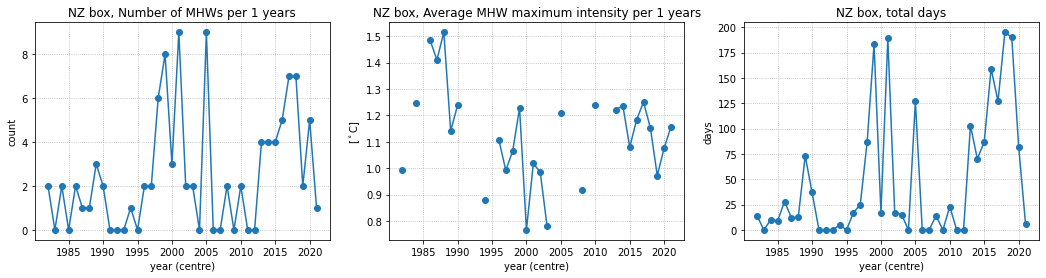

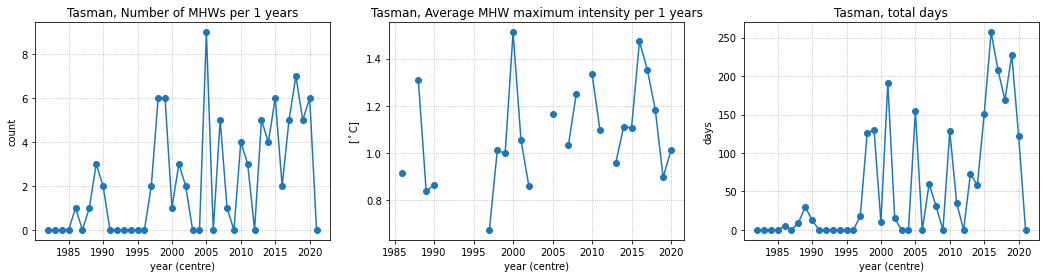

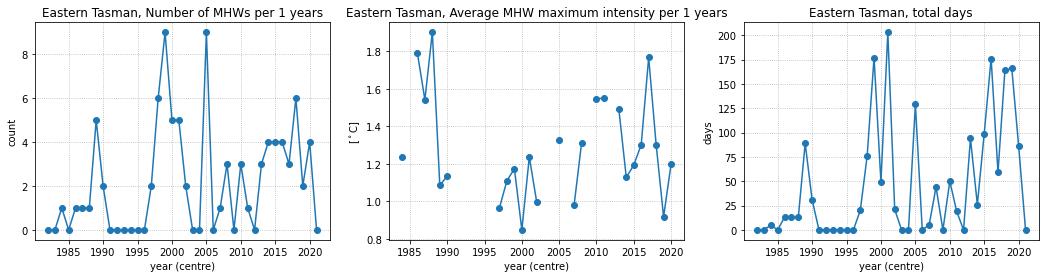

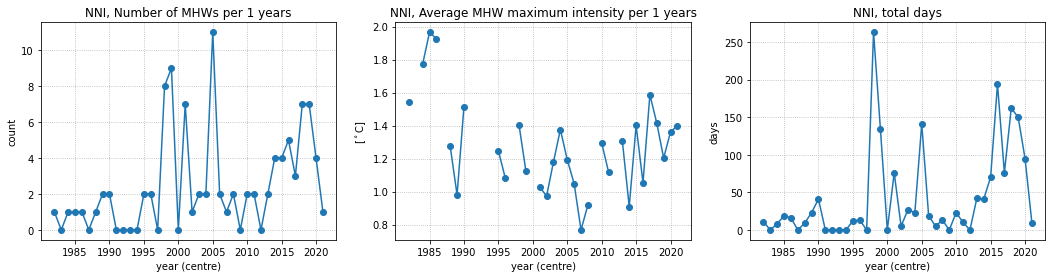

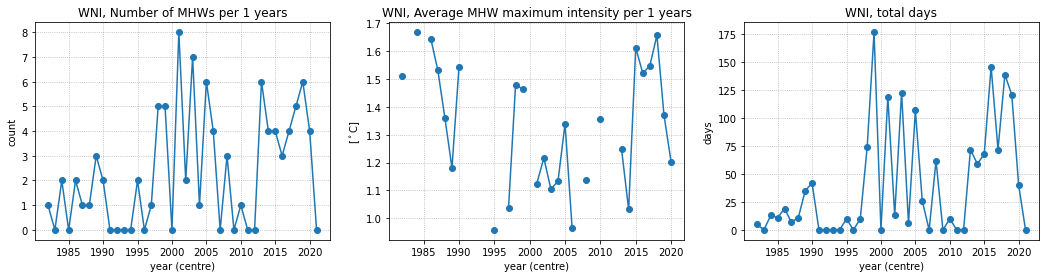

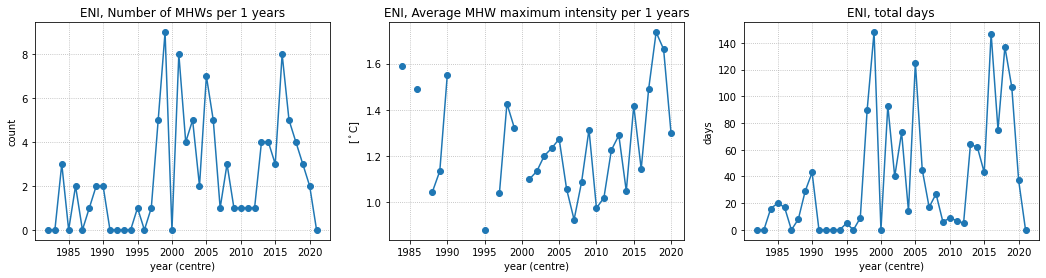

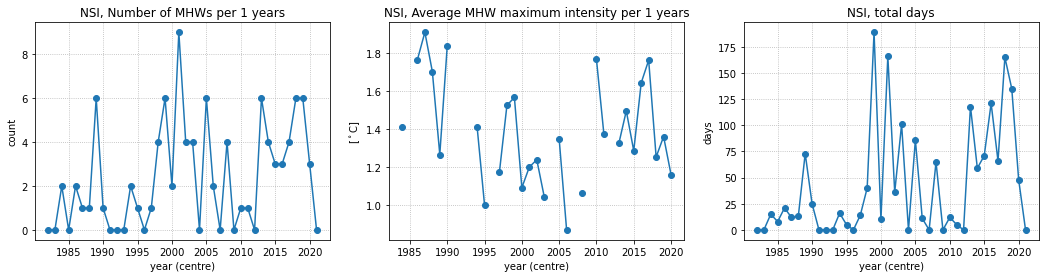

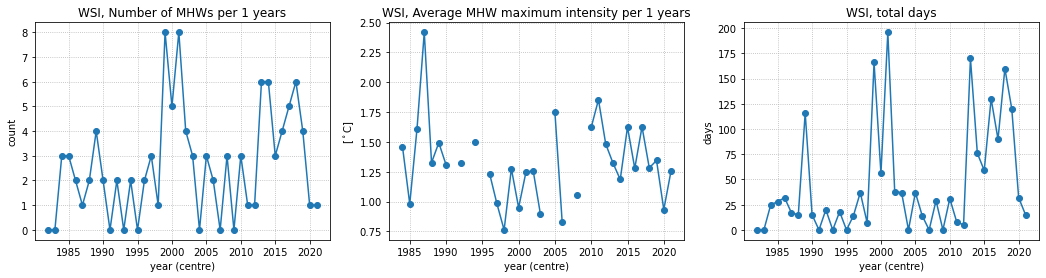

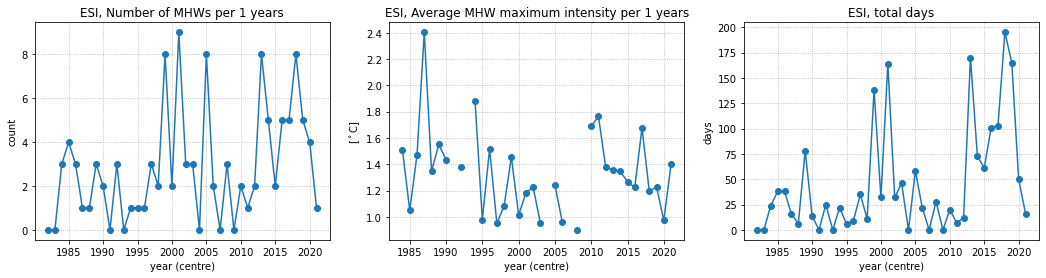

In [51]:
for name in dts.keys(): 

    print(f"------------------------------------------------------------------------------")
    print(f">>>>> {name} <<<<<")
    print(f"------------------------------------------------------------------------------")

    name_fname = name.replace(' ','_')
    
    # detects 
    
    t, mhws, df_mhws, ev = detect_MWHs(dts[name], verbose=True)
    
    # saves to disk the dataframe with the detected MHW events 
    
    df_mhws.to_csv(f'./Detected_MHWs_events_{name_fname}.csv')    
    
    # rank and return period 
    
    rank, returnPeriod = mhw.rank(t, mhws)
    
    print("\nRanks:\n")
    
    print(f"\nThe {mhws['date_start'][ev]:%Y-%m-%d} to {mhws['date_end'][ev]:%Y-%m-%d} MHW event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
    print(f"\nThe {mhws['date_start'][ev]:%Y-%m-%d} to {mhws['date_end'][ev]:%Y-%m-%d} MHW event is ranked number " \
            + str(rank['intensity_max'][ev]) + " by maximum intensity")
    print(f"\nThe {mhws['date_start'][ev]:%Y-%m-%d} to {mhws['date_end'][ev]:%Y-%m-%d} MHW event is ranked number " \
            + str(rank['intensity_mean'][ev]) + " by mean intensity")
    print(f"\nThe {mhws['date_start'][ev]:%Y-%m-%d} to {mhws['date_end'][ev]:%Y-%m-%d} MHW event is ranked number " \
            + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")
    
    # calculate block statistics 
    
    blocks, df_blocks = make_block_average(t, mhws, block_length=block_length)
    
    # mean and trends 
    
    mean, trend, dtrend = mhw.meanTrend(blocks)
    
    print("\nMean and trends:\n")
    
    print("\nThere are on average " + str(mean['count']) + " MHWs in each year, \n \
    with a linear trend of " + str(10*trend['count']) + " MHW events per decade \n \
    This trend is statistically significant (p<0.05): " \
    + str(np.abs(trend['count']) > dtrend['count']) + "\n")

    print("\nThe average maximum intensity is " + str(mean['intensity_max']) + " deg. C, \n \
    with a linear trend of " + str(10*trend['intensity_max']) + " deg. C per decade \n \
    This trend is statistically significant (p<0.05): " \
    + str(np.abs(trend['intensity_max']) > dtrend['intensity_max']))

    print("\nThe average total days is " + str(mean['total_days']) + " days, \n \
    with a linear trend of " + str(10*trend['total_days']) + " days per decade \n \
    This trend is statistically significant (p<0.05): " \
    + str(np.abs(trend['total_days']) > dtrend['total_days']))
    
    # plots 
    
    _ = make_time_series_plot(df_blocks, name_fname=name_fname)
    
    # save block stats to disk 
    
    df_blocks.to_csv(f'./{name_fname}_MHW_stat_per_{block_length}_years.csv') 